# Neural network models

This notebook picks up after the `simple_models` notebook. After trying a range of classification algorithms, we'll try out some of the neural network models in [1]. These include fully-connected models of varying layer sizes, and finally convolutional models including the famous LeNet-5. 

Along the way, we'll be using Keras which is a library sitting on top of Theano or Tensorflow. This allows easy construction, training and evaluation of neural nets. Before we get started, here's a recap of the `simple_models` notebook models.

`[1]` - [Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf),  LeCun et al, Nov 1998

In [1]:
# Load in dependencies, may not use all of these
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

%matplotlib inline

## Load pickle files

In [2]:
# Set up the file directory and names
DIR = '../input/'
X_TRAIN = DIR + 'train-images-idx3-ubyte.pkl'
Y_TRAIN = DIR + 'train-labels-idx1-ubyte.pkl'
X_TEST = DIR + 't10k-images-idx3-ubyte.pkl'
Y_TEST = DIR + 't10k-labels-idx1-ubyte.pkl'

print('Loading pickle files ...')
X_train_input = pickle.load( open( X_TRAIN, "rb" ) )
y_train_input = pickle.load( open( Y_TRAIN, "rb" ) )
X_test_input = pickle.load( open( X_TEST, "rb" ) )
y_test_input = pickle.load( open( Y_TEST, "rb" ) )

n_train = X_train_input.shape[0]
n_test = X_test_input.shape[0]

w = X_train_input.shape[1]
h = X_train_input.shape[2]

# Reshape the images so they're a single row in the numpy array
X_train = X_train_input.reshape((n_train, w * h))
X_test = X_test_input.reshape((n_test, w * h))
y_train = y_train_input.squeeze()
y_test = y_test_input.squeeze()

assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

print('Loaded train images shape {}, labels shape {}'.format(X_train.shape, y_train.shape))
print('Loaded test images shape {}, labels shape {}'.format(X_test.shape, y_test.shape))

Loading pickle files ...
Loaded train images shape (60000, 784), labels shape (60000,)
Loaded test images shape (10000, 784), labels shape (10000,)


## Helper functions

Before trying a few different algorithms out, let's define a reusable set of functions to cross-validate and predict on the test set. Because scikit-learn has such a uniform interface, we can re-use these on pretty much any classification algorithm out there.

In [3]:
# todo !

## Data preparation

Before we start 

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler

# Keras Common configuration
SEED = 1234 # Fix the seed for repeatability
N_JOBS=-2 # Leave 1 core free for UI updates
VERBOSE=2 # 3 is the most verbose level
NB_EPOCH = 20 # todo ! Check how many epochs in the paper
BATCH = 256 # todo ! Check this in the paper too

# Create a stratified, shuffled subset of the training data if needed
N = n_train # How may training examples to use
if N < n_train:
    print('Reducing the X_train size from {} to {} examples'.format(n_train, N))
    X_train, _, y_train, _ = train_test_split(X_train, y_train, 
                                          train_size=N, random_state=SEED)    
    
# Need to convert the classes to one-hot encoding
print('Converting y variables to one-hot encoding')
lbe = LabelBinarizer()
lbe.fit(y_train)
y_train = lbe.transform(y_train)
y_test = lbe.transform(y_test)

print('Z-normalizing X data')
std = StandardScaler()
X_train_float = X_train.astype(np.float32)
X_test_float = X_test.astype(np.float32)
std.fit(X_train.astype(np.float32))
X_train = std.transform(X_train_float)
X_test = std.transform(X_test_float)

print('Train images shape {}, labels shape {}'.format(X_train.shape, y_train.shape))
print('Test images shape {}, labels shape {}'.format(X_test.shape, y_test.shape))

Converting y variables to one-hot encoding
Z-normalizing X data
Train images shape (60000, 784), labels shape (60000, 10)
Test images shape (10000, 784), labels shape (10000, 10)


## [1] C.5 - One hidden layer models

The paper continues with an evaluation of single hidden-layer models. We'll be training a selection of three models from the paper, whhich are listed below.  All use sigmoid activations.

* Model a - 28x28-300-10: 4.7% Error
* Model b - 20x20-300-10:  1.6% Error (images were reduced to 20x20 and centred in 28x28  background)
* Model c - 28x28-1000-10: 4.5% Error


### Model a

This is a baseline FC network which should give 4.7% error. 

In [5]:
# Model a - 28x28-300-10: 4.7% Error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(300, input_dim=784))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('softmax'))
print('Model summary:\n')
model.summary()

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

print('\nTraining model\n')
model.fit(X_train, y_train,
          nb_epoch=NB_EPOCH,
          batch_size=BATCH,
          verbose=2)

print('\nGenerating predictions on test set\n')
scores = model.evaluate(X_test, y_test, batch_size=BATCH)
errors = [1.0 - score for score in scores]

print('\n\nTest set training error {:.4f}, test error {:.4f}'.format(errors[0], errors[1]))

Using Theano backend.


Model summary:

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 300)           235500      dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 300)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 10)            3010        activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 10)            0           dense_2[0][0]                    
Total params: 238510
______________________________________________________

### Model b 

This model requires some preprocessing of the input data, to shrink the images into a 20x20 area centred in a 28x28 image. After that we need to remember to Z-Normalize them again.

In [6]:
X_train_input.shape

(60000, 28, 28)

Showing training image indexes [51286 41937 35725 12564 23876  7104   435 40959 24141 12193 47780  9518
 51821 52610 57377  8901]


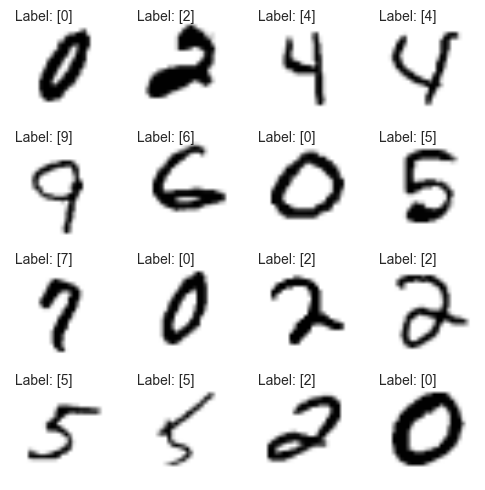

In [57]:
# Check a few training values at random as a sanity check
def show_label_images(X, y, images=None):
    '''Shows random images in a grid
    INPUT: X - image data
           y - class label
           images - indexes of images to show. Randomly selected if None
    RETURNS: Nothing.
    '''
    
    num = 4
    num_square = num ** 2
    
    if images is None:
        images = np.random.randint(0, n_train, num_square)
        
    print('Showing training image indexes {}'.format(images))

    fig, axes = plt.subplots(num,num, figsize=(6,6))
    for idx, val in enumerate(images):
        r, c = divmod(idx, num)
        ax = axes[r][c]
        ax.imshow(X[images[idx]], cmap=plt.cm.binary)
        ax.annotate('Label: {}'.format(y[val]), xy=(1, 1))
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

show_label_images(X_train_input, y_train_input)

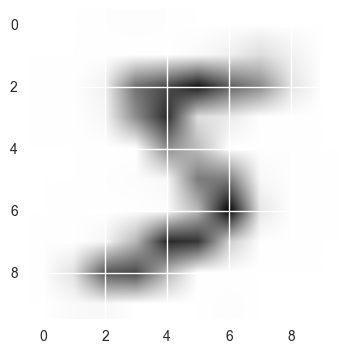

In [68]:
from PIL import Image

img = Image.fromarray(X_train_input[0])

img.thumbnail((10, 10), Image.ANTIALIAS) 
imgplot = plt.imshow(img)

In [9]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 300)           235500      dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 300)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 10)            3010        activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 10)            0           dense_2[0][0]                    
Total params: 238510
______________________________________________________________________

## 